In [81]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta

# Exploratory data analysis

We will limit our data to the country **USA**:

In [82]:
def dataframeByRegion(df, region):
    return df[df['region'] == region]

In [83]:
spotify_data = pd.read_csv("../data/spotify_2020+_cleaned.csv")

In [84]:
spotify_data["date"] = pd.to_datetime(spotify_data["date"])

df_united_states = dataframeByRegion(spotify_data, "United States")
df_united_states

,Unnamed: 0,title,rank,date,artist,region,chart,trend
10961710,10961710,The Box,1,2020-01-01,Roddy Ricch,United States,top200,SAME_POSITION
10961711,10961711,GOODMORNINGTOKYO!,1,2020-01-01,TOKYO’S REVENGE,United States,viral50,SAME_POSITION
10961712,10961712,ROXANNE,2,2020-01-01,Arizona Zervas,United States,top200,SAME_POSITION
10961713,10961713,"All I Want - From ""High School Musical: The Mu...",2,2020-01-01,Olivia Rodrigo,United States,viral50,SAME_POSITION
10961714,10961714,Circles,3,2020-01-01,Post Malone,United States,top200,SAME_POSITION
...,...,...,...,...,...,...,...,...
11144037,11144037,Not Allowed,196,2021-12-31,TV Girl,United States,top200,MOVE_DOWN
11144038,11144038,1 Scale (feat. G Herbo),197,2021-12-31,Young Dolph,United States,top200,NEW_ENTRY
11144039,11144039,MIDDLE CHILD,198,2021-12-31,J. Cole,United States,top200,MOVE_DOWN
11144040,11144040,EVERY CHANCE I GET (feat. Lil Baby & Lil Durk),199,2021-12-31,DJ Khaled,United States,top200,NEW_ENTRY


first, lets check if a song title is aviable both in **top200** and **viral50** charts:

In [85]:
# returns a list of songs which appear both in top200 and viral50 charts
def get_usable_song_titles(my_data):
    data_by_title = my_data.groupby("title")
    usable_titles = []
    
    for (name,group) in data_by_title.__iter__():
        if ("viral50" in group["chart"].unique() ) and ("top200" in group["chart"].unique()):
            usable_titles.append(name)
            
    usable_titles = pd.Series(usable_titles)
    num_title = len(df_united_states["title"].unique())
    
    print(f" titles which appear in both charts: {usable_titles.count()}\n total number of titles: {num_title}")
    
    return usable_titles

In [86]:
usable_titles = get_usable_song_titles(df_united_states)
usable_title_df = df_united_states[df_united_states["title"].isin(usable_titles)]
usable_title_df["title"].count()

 titles which appear in both charts: 747
 total number of titles: 4887


89136

Next, we create two dataframes for our different charts: **Viral50** and **Top200**

In [87]:
viral_50 = usable_title_df[usable_title_df["chart"] == "viral50"]
viral_50.shape

(17114, 8)

In [88]:
viral_50.head()

,Unnamed: 0,title,rank,date,artist,region,chart,trend
10961711,10961711,GOODMORNINGTOKYO!,1,2020-01-01,TOKYO’S REVENGE,United States,viral50,SAME_POSITION
10961713,10961713,"All I Want - From ""High School Musical: The Mu...",2,2020-01-01,Olivia Rodrigo,United States,viral50,SAME_POSITION
10961715,10961715,Blueberry Faygo,3,2020-01-01,Mikey.Otx,United States,viral50,MOVE_UP
10961717,10961717,The Box,4,2020-01-01,Roddy Ricch,United States,viral50,MOVE_DOWN
10961721,10961721,No Idea,6,2020-01-01,Don Toliver,United States,viral50,SAME_POSITION


In [89]:
top_200 = usable_title_df[usable_title_df["chart"] == "top200"]
top_200.head()

,Unnamed: 0,title,rank,date,artist,region,chart,trend
10961710,10961710,The Box,1,2020-01-01,Roddy Ricch,United States,top200,SAME_POSITION
10961712,10961712,ROXANNE,2,2020-01-01,Arizona Zervas,United States,top200,SAME_POSITION
10961716,10961716,BOP,4,2020-01-01,DaBaby,United States,top200,SAME_POSITION
10961720,10961720,Dance Monkey,6,2020-01-01,Tones And I,United States,top200,MOVE_UP
10961722,10961722,Futsal Shuffle 2020,7,2020-01-01,Lil Uzi Vert,United States,top200,MOVE_UP


In order to plot viral rank vs top 200 rank, we need to create a new dataframe:

In [90]:
# returns a dataframe with mean viral50 rank, mean top 200 rank for song title
def get_rank_title_df(titles, viral_50, top_200):
    viral_ranks = []
    top_200_ranks = []
    titles = titles.tolist()
    for my_title in titles:
        viral_rank = viral_50.loc[viral_50["title"] == my_title, ["rank"]].mean()[0]
        viral_ranks.append(viral_rank)
        top_200_rank = top_200.loc[top_200["title"] == my_title, ["rank"]].mean()[0]
        top_200_ranks.append(top_200_rank)
    df = pd.DataFrame(
        {
            "viral_50_rank_mean" : viral_ranks,
            "top_200_rank_mean" : top_200_ranks,
            "title": titles
        }
    )
    return df

In [91]:
rank_title_df = get_rank_title_df(usable_titles, viral_50 = viral_50, top_200 = top_200)
rank_title_df.sample(10)

,viral_50_rank_mean,top_200_rank_mean,title
566,27.400000,88.428571,Street Runner
398,29.000000,90.000000,Mood Ring
30,39.750000,91.166667,Afterglow
538,36.285714,140.800000,Sick and Tired
296,22.833333,176.333333,IDK You Yet
4,37.600000,130.555556,1 Scale (feat. G Herbo)
99,25.659091,98.556818,Breaking Me
459,13.400000,86.702703,Party Girl (Remix)
628,39.857143,142.333333,U Played (feat. Lil Baby)
605,36.714286,59.995781,Therefore I Am


### Plotting mean of ranks against each other:
for the entire two years which our spotify data covers

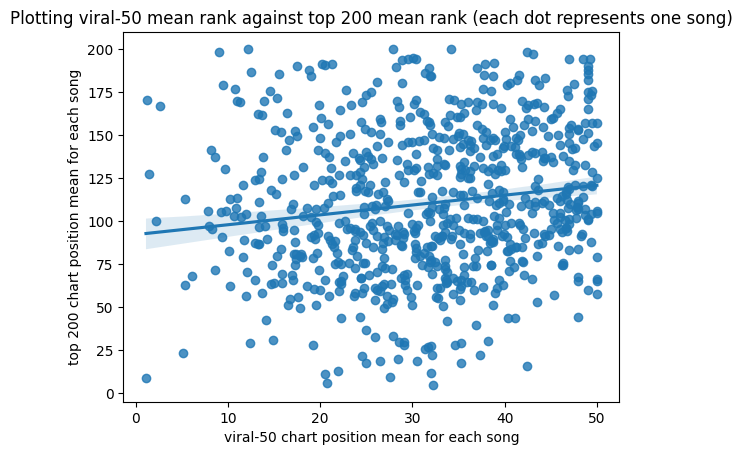

In [92]:
sns.regplot(data=rank_title_df, x = "viral_50_rank_mean", y = "top_200_rank_mean")
plt.title("Plotting viral-50 mean rank against top 200 mean rank (each dot represents one song)")
plt.xlabel("viral-50 chart position mean for each song")
plt.ylabel("top 200 chart position mean for each song")
plt.show()

In [93]:
rank_title_df.corr(method="pearson",numeric_only=True)

,viral_50_rank_mean,top_200_rank_mean
viral_50_rank_mean,1.000000,0.152003
top_200_rank_mean,0.152003,1.000000


As we can see, the viral50 and top 200 ranks are only very weakly correlated. This means that a linear regression model will not suffice to use predict the top200 charts from our viral 50 charts.

## Approach 1: Try to predict top 200 ranking with viral 50 chart position

For this approach we can only use titles which are present in both charts (viral50 and top200), under the condition that one song has a viral50 rank on date $x$ and a rankin in top200 on the date $x + delta$. $delta$ is the delta we can choose freely, meaning it can be either one day, three days or one/multiple weeks and so on. If a title does not fullfil this condition a prediction cannot be made.

In [94]:
# returns a dataframe with mean viral50 rank , mean top 200 rank for song title
def get_rank_title_per_week_df(titles, viral_50, top_200, curr_date = "2020-01-05", delta = 7): 
    date_current = pd.to_datetime(curr_date)
    date_next = date_current + timedelta(days=delta) # date of next week
    
    viral_ranks = []
    top_200_ranks = []
    title_keys = []
    dates_viral = []
    dates_top200 = []
    viral_trends = []
    
    for my_title in titles:
        viral_rank = viral_50.loc[(viral_50["title"] == my_title) & (viral_50["date"] == date_current),["rank"]]
        viral_trend = viral_50.loc[(viral_50["title"] == my_title) & (viral_50["date"] == date_current),["trend"]]
        
        if viral_rank.empty:
            pass
        else:
            viral_ranks.append(viral_rank.iloc[0]["rank"]) # this is a dataframe which should only contain 1 value, we extract it with iloc
            viral_trends.append(viral_trend.iloc[0]["trend"])
            top_200_rank = top_200.loc[(top_200["title"] == my_title) & (top_200["date"] == date_next), ["rank"]]
            
            if top_200_rank.empty:
                # fix viral data entry so length is the same because there is no top200 rank for this viral rank
                if  len(viral_ranks) > 0:
                    viral_ranks.pop()
                    viral_trends.pop()
            else:
                top_200_ranks.append(top_200_rank.iloc[0]["rank"])# this is a dataframe which should only contain 1 value, we extract it with iloc
                title_keys.append(my_title)
                
    for x in title_keys: # add a start and end date entry to each title found in week timespan, so that the arrays match
        dates_viral.append(date_current) #date of viral 50 rank retrieval
        dates_top200.append(date_next) # date of top 200 rank retrieval
    
    df = pd.DataFrame(
        {
            "title": title_keys,
            "date_viral" : dates_viral,
            "viral_50_rank" : viral_ranks,
            "trend_viral_50" : viral_trends,
            "date_top200" : dates_top200,
            "top_200_rank" : top_200_ranks,
            
        }
    )
    
    return df

In [95]:
# method for the export of filtered title data
def filter_titles(freq, delta):
    list_trends = []
    dates_to_predict = pd.date_range(start="2020-01-01", end = "2021-12-31", freq = freq)

    for tmp_date in dates_to_predict:
        list_trends.append(get_rank_title_per_week_df(usable_titles, viral_50 = viral_50, top_200 = top_200, curr_date=tmp_date, delta=delta))
 
    df_tmp = pd.concat(list_trends)

    # change dtype to integer instead of float
    df_tmp['viral_50_rank'] = df_tmp['viral_50_rank'].astype('int64')
    df_tmp['top_200_rank'] = df_tmp['top_200_rank'].astype('int64')

    return df_tmp

In [96]:
df_weekly_with_trends = filter_titles("W", 7)
df_weekly_without_trends = df_weekly_with_trends.drop(columns=['trend_viral_50'])

,title,date_viral,viral_50_rank,trend_viral_50,date_top200,top_200_rank
0,Adore You,2020-01-05,10,SAME_POSITION,2020-01-12,18
1,"All I Want - From ""High School Musical: The Mu...",2020-01-05,2,SAME_POSITION,2020-01-12,66
2,Ayy Macarena,2020-01-05,20,MOVE_DOWN,2020-01-12,143
3,Ballin' (with Roddy Ricch),2020-01-05,38,SAME_POSITION,2020-01-12,13
4,Blinding Lights,2020-01-05,12,SAME_POSITION,2020-01-12,15


In [ ]:
df_weekly_without_trends.head()

,title,date_viral,viral_50_rank,date_top200,top_200_rank
0,Adore You,2020-01-05,10,2020-01-12,18
1,"All I Want - From ""High School Musical: The Mu...",2020-01-05,2,2020-01-12,66
2,Ayy Macarena,2020-01-05,20,2020-01-12,143
3,Ballin' (with Roddy Ricch),2020-01-05,38,2020-01-12,13
4,Blinding Lights,2020-01-05,12,2020-01-12,15


In [97]:
# export dataframe
df_weekly_with_trends.to_csv("../data/viral50to_top200.csv", index=False)

## Approach 2 (extention to approach 1): Try to predict top 200 rankgin with viral 50 charts and trends

With this approach we try to achieve better results in our prediction because viral 50 chart rank alone might not be enough to accurately predict top200 chart rankings. For the prediction we will use both approaches and compare them, to see if there is any difference in the performance of the prediction.  

Here we add the categorial feature `trend` is added. This is the trend of the viral 50 chart position. Since we want to predict from chart viral50 to top200, only song titles with a trend and a viral50 ranking on date x and has a top200 ranking on date x + delta. Like in approach 1, the x can be chosen freely, but we opted for weekly frequency. After filtering the titles we want, we can create a new dataframe and export is as a CSV for the prediction part (see "03_predition.ipynb").

In [1]:

df_weekly_with_trends.head()

NameError: name 'df_weekly_with_trends' is not defined

In [99]:
# export dataframes
df_weekly_without_trends.to_csv("../data/viral50_and_trend_to_top200.csv", index=False)

just to be sure, lets do the same plot for one **week**: we check the viral50 charts of the current day and see if they correlate with the top200 charts 7 days later:


correlation for week starting at: 2020-01-05T00:00:00.000000000
               viral_50_rank  top_200_rank
viral_50_rank       1.000000      0.349135
top_200_rank        0.349135      1.000000

correlation for week starting at: 2020-01-12T00:00:00.000000000
               viral_50_rank  top_200_rank
viral_50_rank       1.000000     -0.015086
top_200_rank       -0.015086      1.000000

correlation for week starting at: 2020-01-19T00:00:00.000000000
               viral_50_rank  top_200_rank
viral_50_rank       1.000000     -0.021252
top_200_rank       -0.021252      1.000000

correlation for week starting at: 2020-01-26T00:00:00.000000000
               viral_50_rank  top_200_rank
viral_50_rank       1.000000     -0.081978
top_200_rank       -0.081978      1.000000

correlation for week starting at: 2020-02-02T00:00:00.000000000
               viral_50_rank  top_200_rank
viral_50_rank       1.000000      0.151241
top_200_rank        0.151241      1.000000

correlation for week starting

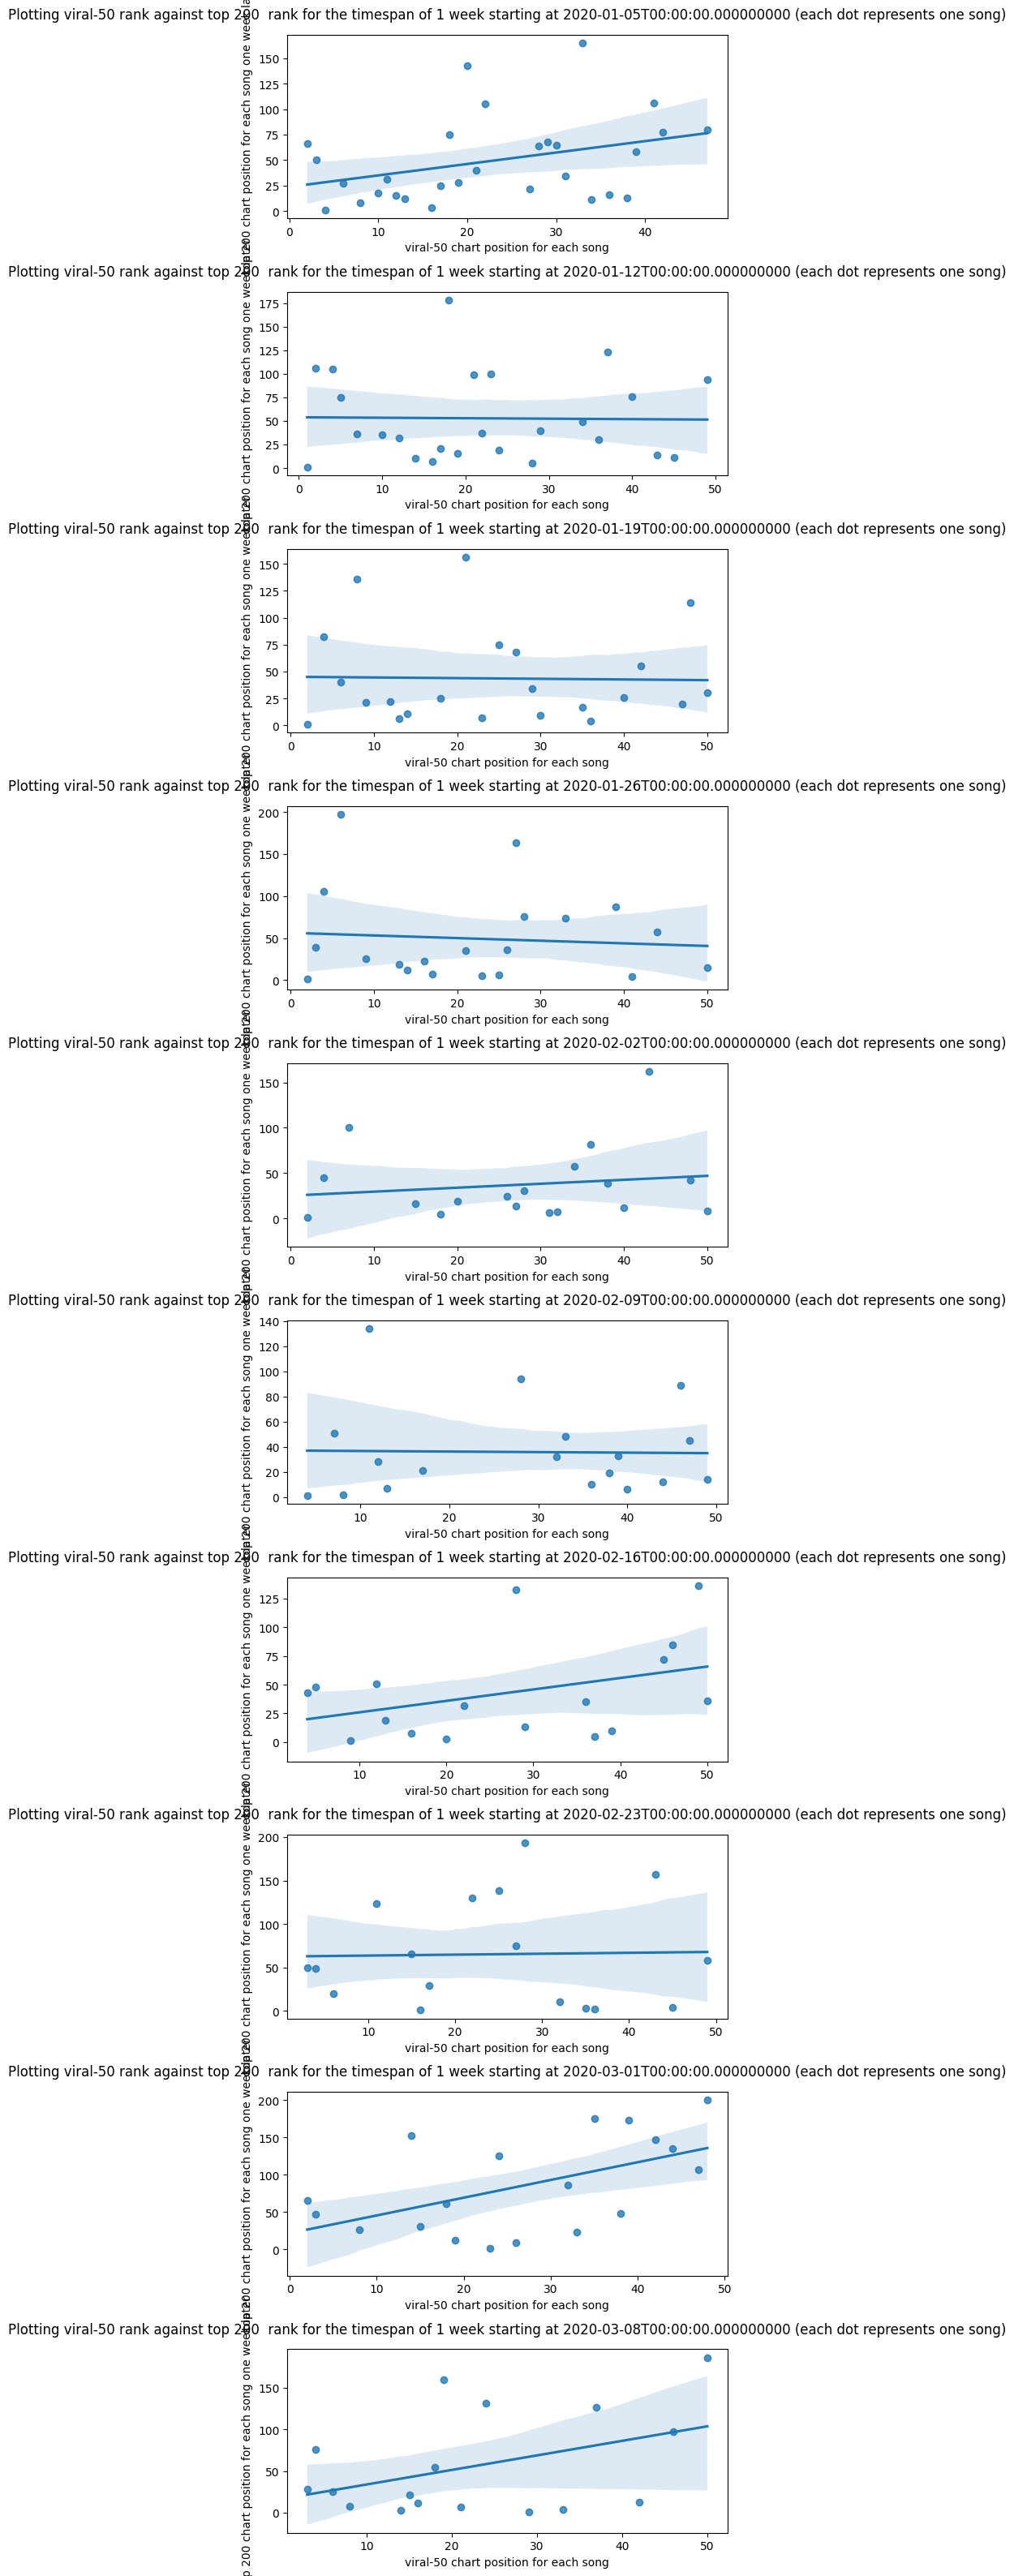

In [100]:
dates = df_weekly_with_trends["date_viral"].unique()
i = 0
number_of_plots = 10

fig, ax = plt.subplots(number_of_plots,figsize=(7,40))
plt.subplots_adjust(hspace=0.4)

for date in dates:
    week = df_weekly_with_trends[df_weekly_with_trends["date_viral"]==date]
    sns.regplot(data=week, x = "viral_50_rank", y = "top_200_rank", ax=ax[i])
    ax[i].set_title(f"Plotting viral-50 rank against top 200  rank for the timespan of 1 week starting at {date} (each dot represents one song)",y=1.05)
    ax[i].set_xlabel("viral-50 chart position for each song")
    ax[i].set_ylabel("top 200 chart position for each song one week later")
    
    print(f"\ncorrelation for week starting at: {date}")
    print(week.corr(method="pearson", numeric_only=True))
    
    i = i+1
    if i >= number_of_plots:
        break
    
fig.show()

We can see that depending on which week we pick, the correlation can be very different. This further supports our discovery from the mean plot.
A possible different approach for our final project could be to look at the **change in rank** instead of the rank itself; if a song moves up in rank over a certain period within the viral50 chart, that could indicate a higher rank in the top 200 chart.

## APPROACH 3: try viral 50 rank to predict top 200 trend

In [101]:
# returns a dataframe with mean viral50 rank , mean top 200 rank for song title
def get_rank_title_per_week_df_for_trends(titles, viral_50, top_200, curr_date = "2020-01-05", delta = 7):
    date_current = pd.to_datetime(curr_date)
    date_next = date_current + timedelta(days=delta)
    viral_ranks = []
    top_200_ranks = []
    title_keys = []
    dates_viral = []
    dates_top200 = []
    trends = []
    for my_title in titles:
        viral_rank = viral_50.loc[(viral_50["title"] == my_title) & (viral_50["date"] == date_current),["rank"]]
        if viral_rank.empty:
            pass
        else:
            viral_ranks.append(viral_rank.iloc[0]["rank"]) # this is a dataframe which should only contain 1 value, we extract it with iloc
            top_200_rank = top_200.loc[(top_200["title"] == my_title) & (top_200["date"] == date_next), ["rank"]]
            trend = top_200.loc[(top_200["title"] == my_title) & (top_200["date"] == date_next),["trend"]]
            if top_200_rank.empty:
                # fix viral data entry so length is the same because there is no top200 rank for this viral rank
                if  len(viral_ranks) > 0:
                    viral_ranks.pop()
            else:
                top_200_ranks.append(top_200_rank.iloc[0]["rank"])# this is a dataframe which should only contain 1 value, we extract it with iloc
                trends.append(trend.iloc[0]["trend"])
                title_keys.append(my_title)
    for x in title_keys: # add a  start and end date entry to each title found in week timespan, so that the arrays match
        dates_viral.append(date_current) #date of viral 50 rank retrieval
        dates_top200.append(date_next) # date of top 200 rank retrieval
    df = pd.DataFrame(
        {
            "title": title_keys,
            "date_viral" : dates_viral,
            "viral_50_rank" : viral_ranks,
            "date_top200" : dates_top200,
            "top_200_rank" : top_200_ranks,
            "trend_top_200" : trends
        }
    )
    return df

In [102]:
# method for the export of filtered title data
def filter_titles_and_export(freq, delta, filename):
    list_trends = []
    dates_to_predict = pd.date_range(start="2020-01-01", end = "2021-12-31", freq = freq)

    for tmp_date in dates_to_predict:
        list_trends.append(get_rank_title_per_week_df_for_trends(usable_titles, viral_50 = viral_50, top_200 = top_200, curr_date=tmp_date, delta=delta))
 
    df_tmp = pd.concat(list_trends)

    # change dtype to integer instead of float
    df_tmp['viral_50_rank'] = df_tmp['viral_50_rank'].astype('int64')
    df_tmp['top_200_rank'] = df_tmp['top_200_rank'].astype('int64')

    df_tmp.to_csv("../data/" + filename, index=False)

    print(f'Successfully exported dataframe with filename: {filename}')

Start export for predictions.

In [103]:
# write data to csv for prediction step
filter_titles_and_export("W", 7, "weekly_ranks_top_200.csv")
filter_titles_and_export("3D", 3, "3_days_ranks_top_200.csv")
filter_titles_and_export("D", 1, "daily_ranks_top_200.csv")

Successfully exported dataframe with filename: weekly_ranks_top_200.csv
Successfully exported dataframe with filename: 3_days_ranks_top_200.csv
Successfully exported dataframe with filename: daily_ranks_top_200.csv
